In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# by Paul Goyes

MT INVERSION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import math
import cmath
import time
from scipy import constants
#start = time.clock();
# Please check the Magnetic Permeability (H/m)
# at: https://docs.scipy.org/doc/scipy-0.14.0/reference/constants.html#module-scipy.constants
mu = constants.mu_0; #Magnetic Permeability (H/m)
def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistivity $(\Omega$m$)$', zlabel='Depth (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

In [ ]:
def randomModel(n=10,depthmax=20000,res=(0,3)):
  indx_rho = np.random.choice(200,n,replace=True)
  # # in Ohm-meter np.abs(np.random.normal(loc=1,scale=2,size=10))/3
  res = np.random.uniform(res[0], res[1], 200)
  resistivities = res[indx_rho];

  dz =   depthmax // (n-1)
  z = np.arange(n)*dz
  thicknesses = np.diff(z)


  return (10**resistivities,thicknesses)

[ 600. 1391. 3795. 4000.]


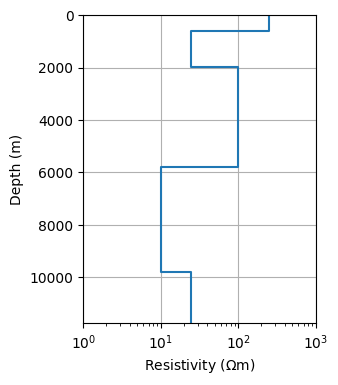

In [ ]:
### from : Exploring nonlinear inversions: A 1D magnetotelluric example

layer_tops = np.r_[0., -600., -1991., -5786., -9786.]  # in m
rho_layers = np.r_[250., 25, 100., 10., 25.]
layer_thicknesses = np.diff(-layer_tops)

fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, layer_thicknesses, rho_layers,plot='semilogx')
plt.xlim([1,10**3])
print(layer_thicknesses)

synthk,synres = layer_thicknesses,rho_layers

In [ ]:
############# from simpeg 10.7 example
#layer_tops = np.r_[0., -600., -1991., -5786., -9786.] #[::-1]  # in m
#layer_thicknesses = np.diff(-layer_tops)
#rho_layers = np.r_[250., 25, 100., 10.,25.] #[::-1]

#fig, ax = plt.subplots(figsize=(3,4))
#drawModel1D(ax, layer_thicknesses, rho_layers,plot='semilogx')
#plt.xlim([1,10**3])

#synthk,synres = layer_thicknesses,rho_layers

[2500 2500]
[ 32.2775453    1.51156793 544.96506072]


(1, 1000)

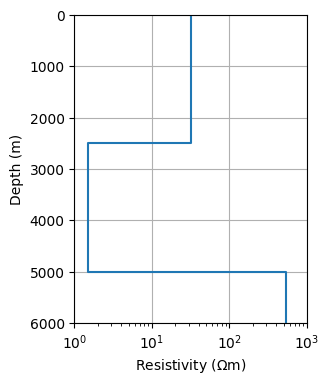

In [ ]:
np.random.seed(1234) # for reproducibility Umair 123456
synres,synthk = randomModel(n=3,depthmax=5000)
print(synthk)
print(synres)
# plot resistivity model

fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, synthk, synres,plot='semilogx')
plt.xlim([1,10**3])

In [ ]:
_, layer_thicknesses_inv =  randomModel(n=5,depthmax=5000)
layer_thicknesses_inv

array([1250, 1250, 1250, 1250])

In [ ]:
np.sum(synthk)

5000

In [ ]:
#@tf.function
def MTforwardModelTF(resistivities):
    frequencies =tf.cast(np.logspace(-3, 2, 31),dtype=tf.complex128)
    thicknesses =tf.cast(layer_thicknesses_inv,dtype=tf.complex128)
    n = len(resistivities)
    resistivities = tf.cast(resistivities,dtype=tf.complex128)
    #apparentResistivity = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True)
    phase = tf.TensorArray(dtype=tf.complex128, size=0, dynamic_size=True)

    for frequency in frequencies:
        w = 2 * math.pi * frequency
        impedances = tf.TensorArray(dtype=tf.complex128, size=n)

        # Compute basement impedance
        impedances = impedances.write(n-1, tf.sqrt(w  *mu*1j * resistivities[n-1]))

        for j in range(n-2, -1, -1):
            resistivity = resistivities[j]
            thickness = thicknesses[j]

            # Compute intrinsic impedance of current layer
            dj = tf.sqrt((w * mu*(1.0/resistivity)) * 1j)
            wj = dj * resistivity

            # Calculate Exponential factor from intrinsic impedance
            ej = tf.exp(-2 * thickness * dj)

            # Calculate reflection coefficient using current layer intrinsic impedance
            # and the below layer impedance
            belowImpedance = impedances.read(j + 1)
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances = impedances.write(j, Zj)

        # Compute apparent resistivity from top layer impedance
        Z = impedances.read(0)
        absZ = tf.abs(Z)
        phase = phase.write(phase.size(), Z)

    return phase.stack()


In [ ]:
z_obs = MTforwardModelTF(synres)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

def build_model(input_dim, output_dim, nc, ly):
    #regout = OuterLayer()
    # Define the input layer



    input_layer = Input(shape=(input_dim,))
    #previous_layer = input_layer
    previous_layer = Dense(nc, activation='relu')(input_layer)
    # Initialize a list to hold the hidden layers tf.keras.layers.LeakyReLU()
    hidden_layers = []

    # Create the hidden layers
    for _ in range(ly):
        hidden_layer = Dense(nc, activation='relu',kernel_regularizer='l1')(previous_layer)
        hidden_layers.append(hidden_layer)
        previous_layer = keras.layers.add([previous_layer, hidden_layer])  # Sum with the previous layer

    # Add the output layer
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)
    #out = regout([output_layer,input_layer])

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage:
input_dim = 31  # Adjust based on your input size
output_dim = 5  # Adjust based on your output size
nc = 128*2  # Number of channels per layer
ly = 5  # Number of layers

MTaeNET = build_model(input_dim, output_dim, nc, ly)

# Compile the model as needed
#model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss and optimizer as needed


#tf.keras.utils.plot_model(MTaeNET,show_shapes=True)
MTaeNET.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 dense_28 (Dense)            (None, 256)                  8192      ['input_5[0][0]']             
                                                                                                  
 dense_29 (Dense)            (None, 256)                  65792     ['dense_28[0][0]']            
                                                                                                  
 add_20 (Add)                (None, 256)                  0         ['dense_28[0][0]',            
                                                                     'dense_29[0][0]']      

In [ ]:
0.5*tf.norm(z_obs -   MTforwardModelTF(10**(3*tf.reshape(MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1))),(-1,))))  ,2)
#MTforwardModelTF(1000*tf.reshape(MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1))),(-1,)))
#1000*tf.reshape(MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1))),(-1,))
#10**(3*tf.reshape(MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1))),(-1,)))
#MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1)))


<tf.Tensor: shape=(), dtype=complex128, numpy=(0.010322891370840873-3.498074850631016e-20j)>

In [ ]:
#L2model= MT.r.numpy()
#L2model = tf.constant(L2model,dtype=tf.float64)
#L2model

In [ ]:
initial_learning_rate = 1e-3
optimizern = tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate)

@tf.function
def trainDL():

  with tf.GradientTape() as tape:
    res_pred = 10**(3*MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1)), training=True))
    #modelreg = tf.cast(1e-3*tf.norm( tf.cast(tf.math.log(L2model),tf.float64)-tf.cast(tf.math.log(tf.reshape(res_pred,(-1,))),tf.float64)  ,2 ),dtype=tf.float64 )
    loss = tf.math.real(0.5*tf.norm(tf.math.log(z_obs) - tf.math.log(MTforwardModelTF(tf.reshape(res_pred,(-1,)))) ,2)) #+ modelreg

  grads = tape.gradient(loss, MTaeNET.trainable_weights)
  optimizern.apply_gradients(zip(grads, MTaeNET.trainable_weights))

  return loss
  #print(res_pred)




In [ ]:

from tqdm import trange
loss = []
pbar = trange(500)
for i in pbar:
  los = trainDL()
  pbar.set_postfix(LOSS=los.numpy())
  loss.append(los.numpy())

100%|██████████| 500/500 [01:25<00:00,  5.87it/s, LOSS=0.0304]


In [ ]:
res_pred = 10**(3*MTaeNET(tf.reshape(tf.abs(z_obs),(1,-1)), training=False))
res_pred

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 31.740768 ,  32.100464 ,   1.5139804,   1.5166366, 540.274    ]],
      dtype=float32)>

In [ ]:
state=[]
@tf.function
def train(MT,optimizer):
  with tf.GradientTape(persistent=True) as t2:
    with tf.GradientTape(persistent=True) as tape:
      z_pred = MTforwardModelTF(MT.r)
      loss = tf.math.real(0.5*tf.norm( tf.math.log(z_pred) - tf.math.log(z_obs) ,2)) #+ 0.0001*tf.reduce_sum(tf.square(MT.r[1:]-MT.r[:-1]))


    # Compute the gradient inside the outer `t2` context manager
    # which means the gradient computation is differentiable as well.
    grads = tape.gradient(loss, MT.trainable_variables)

  #d2z_dx2 = t2.jacobian(grads, MT.r,experimental_use_pfor=False)



  optimizer.apply_gradients(zip(grads, MT.trainable_variables))
  #n_params = tf.reduce_prod(MT.r.shape)
  #g_vec = tf.reshape(grads, [n_params, 1])
  #h_mat = tf.reshape(d2z_dx2, [n_params, n_params])

  #eps = 1e-3
  #eye_eps = tf.cast(tf.eye(h_mat.shape[0])*eps,dtype=tf.float64)
  #update = tf.linalg.solve(h_mat + eye_eps, g_vec)
  #update = tf.tensordot(tf.linalg.inv(h_mat + eye_eps),g_vec,axes=1)
  #print(update)
  #MT.r.assign_sub(tf.reshape(update,MT.r.shape))
  #print(tf.reshape(update,m.x.shape))
  return loss

In [ ]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-1)

MT = tf.Module()
init_val = 100*tf.ones(5,dtype=tf.float64)
#init_val = tf.cast(tf.reshape(res_pred,(-1,)),dtype=tf.float64) #solution from DL

MT.r = tf.Variable(initial_value=init_val)


train(MT,optimizer)
#init_val
len(init_val)

5

In [ ]:
from tqdm import trange

pbar = trange(500)

loss_l2 = []

state=[]
init_val = tf.cast(tf.reshape(res_pred,(-1,)),dtype=tf.float64)
for i in pbar:
  los = train(MT,optimizer)
  pbar.set_postfix(LOSS=los.numpy())
  loss_l2.append(los.numpy())

100%|██████████| 500/500 [01:21<00:00,  6.13it/s, LOSS=0.244]


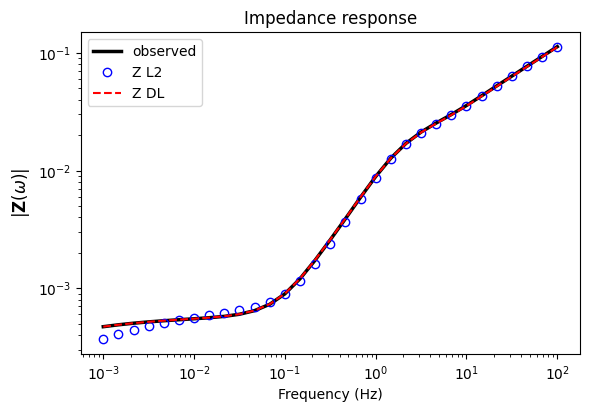

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(np.logspace(-3, 2, 31),z_obs,'k',label='observed',linewidth=2.5)
ax.loglog(np.logspace(-3, 2, 31),MTforwardModelTF(MT.r.numpy()),'ob',markerfacecolor="None",label='Z L2')
ax.loglog(np.logspace(-3, 2, 31),MTforwardModelTF(tf.reshape(res_pred,(-1,))),'--r',label='Z DL')

ax.set_ylabel("$|\mathbf{Z}(\omega)|$", fontsize=12)
ax.set_xlabel("Frequency (Hz)", fontsize=10)
plt.legend()
plt.tight_layout()
plt.title('Impedance response')

#plt.savefig('Z_response.pdf',dpi=300)
plt.show()

0.03041655840130875
0.24404001216672427


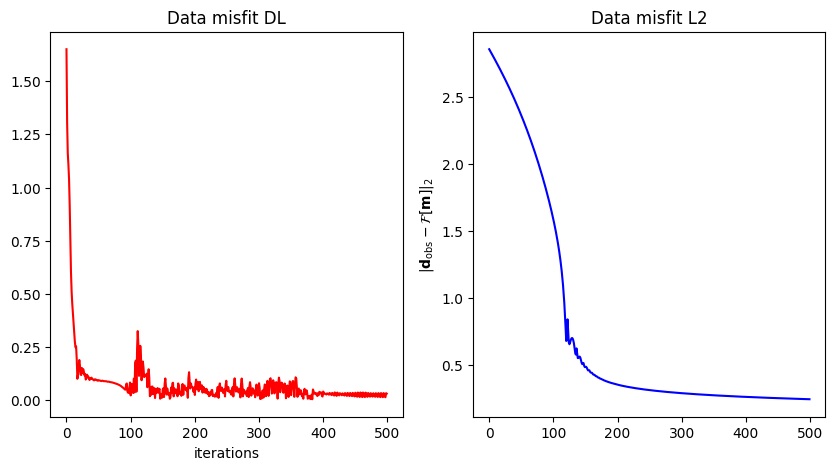

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss,'r',label='loss_DL')
plt.title('Data misfit DL')
plt.xlabel('iterations')


plt.subplot(122)
plt.plot(loss_l2,'b',label='Loss L2-norm')
plt.ylabel('$| \mathbf{d}_{\mathrm{obs}}- \mathcal{F}[\mathbf{m}] |_2$')
plt.title('Data misfit L2')

#plt.savefig('datamisfit.pdf',dpi=300)
print(loss[-1])
print(loss_l2[-1])

In [ ]:
MT.r



<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([29.39349974, 24.3945688 , 24.56288424, 25.43489776, 26.23946282,
       26.96112027, 27.58581538, 28.09937921, 28.48797303, 91.61595193])>

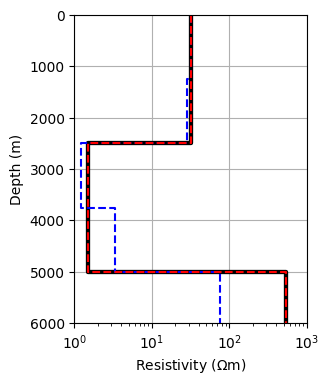

In [ ]:
#layer_thicknesses_inv

fig, ax = plt.subplots(figsize=(3,4))
drawModel1D(ax, synthk, synres,plot='semilogx',color='black',linewidth=3.1)

drawModel1D(ax, layer_thicknesses_inv, MT.r.numpy(),plot='semilogx',color='blue',linestyle='dashed')
drawModel1D(ax, layer_thicknesses_inv, tf.reshape(res_pred,(-1,)).numpy(),plot='semilogx',color='red',linestyle='dashed')
#

plt.xlim([1,10**3])

#plt.savefig('inverted_model.pdf',dpi=300)